# Imports and Definitions

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import os
import shutil
import csv
from datetime import datetime

In [2]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cwd = os.getcwd()
dataset_dir = os.path.join(cwd, 'MaskDataset')
if os.path.exists(dataset_dir):
  shutil.rmtree(dataset_dir)
!unzip '/content/drive/My Drive/Keras3/MaskDataset'

Output streaming troncato alle ultime 5000 righe.
  inflating: MaskDataset/training/0/12637.jpg  
  inflating: MaskDataset/training/0/12638.jpg  
  inflating: MaskDataset/training/0/12639.jpg  
  inflating: MaskDataset/training/0/12644.jpg  
  inflating: MaskDataset/training/0/12650.jpg  
  inflating: MaskDataset/training/0/12652.jpg  
  inflating: MaskDataset/training/0/12655.jpg  
  inflating: MaskDataset/training/0/12658.jpg  
  inflating: MaskDataset/training/0/12663.jpg  
  inflating: MaskDataset/training/0/12666.jpg  
  inflating: MaskDataset/training/0/12667.jpg  
  inflating: MaskDataset/training/0/12668.jpg  
  inflating: MaskDataset/training/0/12672.jpg  
  inflating: MaskDataset/training/0/12678.jpg  
  inflating: MaskDataset/training/0/12681.jpg  
  inflating: MaskDataset/training/0/12684.jpg  
  inflating: MaskDataset/training/0/12689.jpg  
  inflating: MaskDataset/training/0/12700.jpg  
  inflating: MaskDataset/training/0/12703.jpg  
  inflating: MaskDataset/training/0/12

In [5]:
def create_csv(results, results_dir):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [6]:
def shuffle_validation_weighted(base_dir, split = 0.2, reset = False):
    # Create validation_set weighted on number of occurrences in training_set
    train_dir = os.path.join(base_dir, 'training')
    valid_dir = os.path.join(base_dir, 'validation')

    if not reset:
        # First identify training and validation dir
        if not os.path.exists(valid_dir):
            os.makedirs(valid_dir)

        # Count elements in each dir in training
        class_and_card = {name: len(os.listdir(os.path.join(train_dir, name))) for name in os.listdir(train_dir) if
                          os.path.join(train_dir, name)}

        print(class_and_card)
        # Get images per class wrt total images
        class_and_card_validation = {name: int(class_and_card[name] * split) for name in class_and_card}

        print(class_and_card_validation)
        # Select images to move
        for key, item in class_and_card_validation.items():
            source_dir = os.path.join(train_dir, key)
            images = os.listdir(source_dir)
            np.random.shuffle(images)
            target_dir = os.path.join(valid_dir, key)
            if not os.path.exists(target_dir):
                os.makedirs(target_dir)
            for i in range(item):
                shutil.move(os.path.join(source_dir, images[i]), target_dir)
    else:
        # Restore initial state
        # For each class, move images to train_dir in respective folders
        classes = [name for name in os.listdir(valid_dir)]
        for class_name in classes:
            source_dir = os.path.join(valid_dir, class_name)
            images = os.listdir(source_dir)
            target_dir = os.path.join(train_dir, class_name)
            for img in images:
                shutil.move(os.path.join(source_dir, img), target_dir)

# Hyperparameters and Callbacks

In [7]:
# We executed a scoped GridSearch on the following parameters
# Dense Layers -> [1] (tested parameters)
# Neurons Number -> [256, 512]
# Image Size -> [352] (same for heigth and width)
# Batch Size -> [16]
# Valid Percentage -> [0.2]
# Starting Learning Rate -> [1e-3]
# LR1 values -> [0]
# LR2 values -> [0, 0.0001]
# Below we have the best parameters

img_w, img_h = 352, 352
num_classes = 3

name = "vgg19"
preprocessing = tf.keras.applications.vgg19.preprocess_input
base_model = keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(img_w, img_h, 3))
SEED = 95935
np.random.seed(SEED)

batch_size = 16
valid_split_perc = 0.2
epochs_fine = 200
learning_rate = 1e-3

dropout_rate = 0.3
dense_neurons = 512
train_after_layer = 21

l1 = 0
l2 = 0.0001

80142336/80134624 [==============================] - 0s 0us/step


In [8]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 8)
cb_checkpointer = ModelCheckpoint(filepath = name + '_1.hdf5', monitor = 'val_loss', save_best_only = True)
cb_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=4, min_lr=5e-5)

# Dataset Loading and Preprocessing

In [9]:
shuffle_validation_weighted(dataset_dir, split=valid_split_perc, reset=False)
shuffle_validation_weighted(dataset_dir, split=valid_split_perc, reset=True)
shuffle_validation_weighted(dataset_dir, split=valid_split_perc, reset=False)

{'2': 1817, '1': 1897, '0': 1900}
{'2': 363, '1': 379, '0': 380}
{'2': 1817, '1': 1897, '0': 1900}
{'2': 363, '1': 379, '0': 380}


In [10]:
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode="nearest",
                                   preprocessing_function=preprocessing)

train_generator = train_datagen.flow_from_directory(os.path.join(dataset_dir, 'training'),
                                                    target_size=(img_w, img_h),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    seed = SEED)

val_datagen = ImageDataGenerator(preprocessing_function=preprocessing)

val_generator = val_datagen.flow_from_directory(os.path.join(dataset_dir, 'validation'),
                                                target_size=(img_w, img_h),
                                                batch_size=batch_size,
                                                shuffle=False,
                                                class_mode='categorical',
                                                seed = SEED)

Found 4492 images belonging to 3 classes.
Found 1122 images belonging to 3 classes.


# Model Definition

In [11]:
for layer in base_model.layers[:train_after_layer]:
    if isinstance(layer, layers.Conv2D):
        layer.trainable = False

base_model.summary()
print('BLOCKING ALL LAYERS BEFORE: ' + base_model.layers[train_after_layer].name)
print('TOTAL NUMBER OF LAYERS: ' + str(len(base_model.layers)))

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 352, 352, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 352, 352, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 352, 352, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 176, 176, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 176, 176, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 176, 176, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 88, 88, 128)       0     

In [12]:
model = keras.models.Sequential()

for l in base_model.layers:
    if isinstance(l,keras.layers.Conv2D):
        model.add(l)
        model.add(tf.keras.layers.BatchNormalization())
    else:
        model.add(l)

model.add(layers.Flatten())
model.add(layers.Dense(dense_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 352, 352, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 352, 352, 64)      256       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 352, 352, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 352, 352, 64)      256       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 176, 176, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 176, 176, 128)     73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 176, 176, 128)     5

# Training (1 - Locked)

In [13]:
for l in model.layers:
    if l.name == "block5_pool": 
        break
    else:
        if isinstance(l, layers.Conv2D):
            l.trainable = False


Epoch 1/200
281/281 [==============================] - 202s 717ms/step - loss: 3.9636 - accuracy: 0.3776 - val_loss: 1.6331 - val_accuracy: 0.4456
Epoch 2/200
281/281 [==============================] - 195s 694ms/step - loss: 1.3965 - accuracy: 0.4323 - val_loss: 1.2703 - val_accuracy: 0.5134
Epoch 3/200
281/281 [==============================] - 191s 681ms/step - loss: 1.3265 - accuracy: 0.4595 - val_loss: 1.1417 - val_accuracy: 0.5802
Epoch 4/200
281/281 [==============================] - 191s 678ms/step - loss: 1.2551 - accuracy: 0.4987 - val_loss: 1.0587 - val_accuracy: 0.6221
Epoch 5/200
281/281 [==============================] - 191s 678ms/step - loss: 1.2135 - accuracy: 0.5280 - val_loss: 1.0121 - val_accuracy: 0.6007
Epoch 6/200
281/281 [==============================] - 190s 678ms/step - loss: 1.1490 - accuracy: 0.5643 - val_loss: 0.9746 - val_accuracy: 0.6506
Epoch 7/200
281/281 [==============================] - 191s 679ms/step - loss: 1.1036 - accuracy: 0.5761 - val_loss: 0

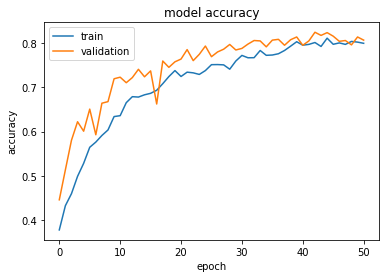

In [14]:
hist = model.fit(train_generator,
                 steps_per_epoch=len(train_generator),
                 epochs=epochs_fine,
                 validation_data=val_generator,
                 validation_steps=len(val_generator),
                 callbacks=[cb_checkpointer, cb_early_stopper, cb_plateau],
                 verbose = 1)

plot_hist(hist)

# BEST RESULT --> Epoch 43/200 192s 682ms/step - loss: 0.6237 - accuracy: 0.8012 - val_loss: 0.5733 - val_accuracy: 0.8244

# Training (2 - Partially Unlocked)

In [16]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 8)
cb_checkpointer = ModelCheckpoint(filepath = name + '_2.hdf5', monitor = 'val_loss', save_best_only = True)
cb_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=5e-6)

In [ ]:
model.load_weights(name + "_1.hdf5")
learning_rate = 1e-4
train_after_layer = 16

for l in model.layers:
    if l.name == "block4_pool": 
        break
    else:
        if isinstance(l, layers.Conv2D):
            l.trainable = True

base_model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

hist = model.fit(train_generator,
                 steps_per_epoch=len(train_generator),
                 epochs=epochs_fine,
                 validation_data=val_generator,
                 validation_steps=len(val_generator),
                 callbacks=[cb_checkpointer, cb_early_stopper, cb_plateau],
                 verbose = 1)

plot_hist(hist)

# BEST RESULT --> Epoch 25/200 218s 775ms/step - loss: 0.3365 - accuracy: 0.9192 - val_loss: 0.2984 - val_accuracy: 0.9323

# Training (3 - Unlocked)

In [18]:
cb_early_stopper = EarlyStopping(monitor = 'val_accuracy', patience = 8)
cb_checkpointer = ModelCheckpoint(filepath = name + '_3.hdf5', monitor = 'val_accuracy', save_best_only = True)
cb_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=4, min_lr=1e-6)

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 352, 352, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 352, 352, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 352, 352, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 176, 176, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 176, 176, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 176, 176, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 88, 88, 128)       0     

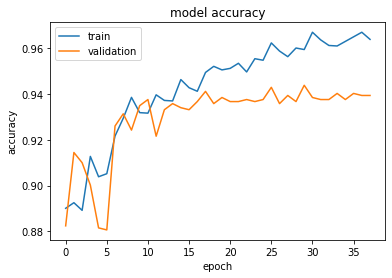

In [19]:
model.load_weights(name + "_2.hdf5")
learning_rate = 5e-5

for layer in base_model.layers:
    layer.trainable = True

base_model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

hist = model.fit(train_generator,
                 steps_per_epoch=len(train_generator),
                 epochs=epochs_fine,
                 validation_data=val_generator,
                 validation_steps=len(val_generator),
                 callbacks=[cb_checkpointer, cb_early_stopper, cb_plateau],
                 verbose = 1)

plot_hist(hist)

# BEST RESULT --> Epoch 30/200 229s 814ms/step - loss: 0.1940 - accuracy: 0.9595 - val_loss: 0.2668 - val_accuracy: 0.9439

# Testing and Creating CSV

In [21]:
model.load_weights(name + "_3.hdf5")

test_dir = os.path.join(dataset_dir, 'test')

test_data_gen = ImageDataGenerator(preprocessing_function=preprocessing)

test_gen = test_data_gen.flow_from_directory(test_dir, target_size=(img_h, img_w),
                                             color_mode='rgb',
                                             class_mode='categorical',
                                             classes = None,
                                             batch_size=1,
                                             shuffle=False)
test_gen.reset()

predictions = model.predict(test_gen, verbose=1)

results = {}

images = test_gen.filenames
i = 0

for p in predictions:
  prediction = np.argmax(p)
  import ntpath
  image_name = ntpath.basename(images[i])
  results[image_name] = str(prediction)
  i = i + 1
  
create_csv(results, cwd)

Found 450 images belonging to 1 classes.
450/450 [==============================] - 11s 24ms/step
